In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
our_path_images = '/content/drive/MyDrive/Digethic-ProjectWork/data/images/'
our_path_labels = '/content/drive/MyDrive/Digethic-ProjectWork/data/labels/'
our_path_data = '/content/drive/MyDrive/Digethic-ProjectWork/data/'

### The code below is structured in three parts: 
###### (1) Data Loading & Pre-Processing
###### (2) Multioutput CNN Modell Version1 
###### (3) Transform images to tensors and save
###### (4) Load Tensor File
###### (5) Second mCNN Modell version
###### (6) Thrid and FINAL Version
###### (7) Performance and Accuracy

# (1) DATA LOADING & PRE-PROCESSING

### Data Preparation
access the JSON-Files and extract the Information on each label

In [28]:
import os
import json
import pandas as pd
import numpy as np

def load_json_files(directory):
    data_list = []

    for filename in os.listdir(directory):
        if filename.endswith('.json'):

            with open(os.path.join(directory, filename), 'r') as file:
                data = json.load(file)
                data['filename'] = filename
                data_list.append(data)

    df = pd.DataFrame(data_list)
    return df

directory = our_path_labels

df = load_json_files(directory)


In [29]:
data = df.copy()

In [ ]:
import os

def find_and_remove_files_with_substring(directory, substring):

    files = os.listdir(directory)


    for file in files:
        if substring in file:
            file_path = os.path.join(directory, file)
            print(f"Removing file: {file_path}")
            os.remove(file_path)

directory_path = our_path_labels

find_and_remove_files_with_substring(directory_path, '(1)')


### data preprocessing

fetch images and connect front and back images insert them into a pandas table "data"

In [30]:
data['image_name'] = data['filename'].str[7:-5]

df_front = data.copy()
df_front.image_name = 'front_'+ df_front.image_name + '.jpg'
df_back = data.copy()
df_back.image_name = 'back_'+ df_back.image_name + '.jpg'
data = pd.concat([df_front, df_back])
data.image_name = 'images/'+ data.image_name
del df_front, df_back

the same for contrast images

In [31]:
data_mask = data.copy()
data_mask['image_name'] = data_mask['image_name'].str[7:-4]
data_mask.image_name = 'masks/' + data_mask.image_name + '.bmp'

integrate the two data - packages into a pandas table "data"

In [32]:
data = pd.concat([data, data_mask])
del data_mask

show content of "data"

In [33]:
data

,category,condition,type,pilling,stains,filename,image_name
0,Ladies,3,Dress,1,True,labels_2022_11_25_13_18_22.json,images/front_2022_11_25_13_18_22.jpg
1,Ladies,2,Cardigan,5,False,labels_2023_02_02_09_58_03.json,images/front_2023_02_02_09_58_03.jpg
2,Ladies,4,Dress,4,False,labels_2022_11_18_08_35_45.json,images/front_2022_11_18_08_35_45.jpg
3,Ladies,2,Blouse,4,False,labels_2023_02_13_09_45_20.json,images/front_2023_02_13_09_45_20.jpg
4,Ladies,5,Top,5,False,labels_2022_10_26_12_28_00.json,images/front_2022_10_26_12_28_00.jpg
...,...,...,...,...,...,...,...
3047,Ladies,2,Dress,2,True,labels_2022_09_02_08_54_08.json,masks/back_2022_09_02_08_54_08.bmp
3048,Ladies,2,Sweater,3,False,labels_2022_10_13_10_43_54.json,masks/back_2022_10_13_10_43_54.bmp
3049,Ladies,5,Top,5,False,labels_2022_10_03_06_18_36.json,masks/back_2022_10_03_06_18_36.bmp
3050,Ladies,2,Cardigan,4,True,labels_2022_10_25_09_06_03.json,masks/back_2022_10_25_09_06_03.bmp


### limit to "Ladies", drop non-relevant data and save to pickle

In [34]:
data.type.value_counts()

type
Sweater     1672
Blouse      1596
Top         1580
T-shirt     1528
None        1524
Dress       1224
Shirt       1128
Cardigan     948
Tank top     768
Jacker       240
Name: count, dtype: int64

reduce the pandas table "datap" to only data-instances in category "Ladies"

In [35]:
data = data[data.category == 'Ladies']

show the content of table "data"

In [36]:
data

,category,condition,type,pilling,stains,filename,image_name
0,Ladies,3,Dress,1,True,labels_2022_11_25_13_18_22.json,images/front_2022_11_25_13_18_22.jpg
1,Ladies,2,Cardigan,5,False,labels_2023_02_02_09_58_03.json,images/front_2023_02_02_09_58_03.jpg
2,Ladies,4,Dress,4,False,labels_2022_11_18_08_35_45.json,images/front_2022_11_18_08_35_45.jpg
3,Ladies,2,Blouse,4,False,labels_2023_02_13_09_45_20.json,images/front_2023_02_13_09_45_20.jpg
4,Ladies,5,Top,5,False,labels_2022_10_26_12_28_00.json,images/front_2022_10_26_12_28_00.jpg
...,...,...,...,...,...,...,...
3047,Ladies,2,Dress,2,True,labels_2022_09_02_08_54_08.json,masks/back_2022_09_02_08_54_08.bmp
3048,Ladies,2,Sweater,3,False,labels_2022_10_13_10_43_54.json,masks/back_2022_10_13_10_43_54.bmp
3049,Ladies,5,Top,5,False,labels_2022_10_03_06_18_36.json,masks/back_2022_10_03_06_18_36.bmp
3050,Ladies,2,Cardigan,4,True,labels_2022_10_25_09_06_03.json,masks/back_2022_10_25_09_06_03.bmp


In [37]:
data.type.value_counts()

type
Blouse      1592
Sweater     1576
Top         1564
T-shirt     1400
Dress       1212
None        1148
Shirt       1024
Cardigan     944
Tank top     768
Jacker       240
Name: count, dtype: int64

change the class - output of the feature "type" from string to a number (0 to 9)

In [ ]:
data.condition = data.condition - 1

data['type'] = np.where(data['type'] == 'Blouse', 0, data['type'])
data['type'] = np.where(data['type'] == 'Sweater', 1, data['type'])
data['type'] = np.where(data['type'] == 'Top', 2, data['type'])
data['type'] = np.where(data['type'] == 'T-shirt', 3, data['type'])
data['type'] = np.where(data['type'] == 'Dress', 4, data['type'])
data['type'] = np.where(data['type'] == 'None', 5, data['type'])
data['type'] = np.where(data['type'] == 'Shirt', 6, data['type'])
data['type'] = np.where(data['type'] == 'Cardigan', 7, data['type'])
data['type'] = np.where(data['type'] == 'Tank top', 8, data['type'])
data['type'] = np.where(data['type'] == 'Jacker', 9, data['type'])

data.stains = data.stains.astype('int')

show the changes in data

In [39]:
data

,category,condition,type,pilling,stains,filename,image_name
0,Ladies,2,4,1,1,labels_2022_11_25_13_18_22.json,images/front_2022_11_25_13_18_22.jpg
1,Ladies,1,7,5,0,labels_2023_02_02_09_58_03.json,images/front_2023_02_02_09_58_03.jpg
2,Ladies,3,4,4,0,labels_2022_11_18_08_35_45.json,images/front_2022_11_18_08_35_45.jpg
3,Ladies,1,0,4,0,labels_2023_02_13_09_45_20.json,images/front_2023_02_13_09_45_20.jpg
4,Ladies,4,2,5,0,labels_2022_10_26_12_28_00.json,images/front_2022_10_26_12_28_00.jpg
...,...,...,...,...,...,...,...
3047,Ladies,1,4,2,1,labels_2022_09_02_08_54_08.json,masks/back_2022_09_02_08_54_08.bmp
3048,Ladies,1,1,3,0,labels_2022_10_13_10_43_54.json,masks/back_2022_10_13_10_43_54.bmp
3049,Ladies,4,2,5,0,labels_2022_10_03_06_18_36.json,masks/back_2022_10_03_06_18_36.bmp
3050,Ladies,1,7,4,1,labels_2022_10_25_09_06_03.json,masks/back_2022_10_25_09_06_03.bmp


drop from the pandas table "data" the columns "filename", "category", "indes" and "pilling"

In [40]:
data = data.drop(columns='filename')
data.drop(columns = ['category','pilling'],inplace=True)
data.image_name = our_path_data + data.image_name

In [41]:
data = data.reset_index().drop(columns='index')

save the dataset as a pickle-file (inorder to protect it from unintended changes while testing)

In [42]:
data.to_pickle(our_path_data+"dataframe.pkl")

# (2) Multioutput CNN Modell Version 1: 
with a dataloader and tensor transformer, 2 convo/pooling layer,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

Epoch 1/25, Train Loss: 8.7403, Val Loss: 8.7220
Epoch 2/25, Train Loss: 6.4788, Val Loss: 5.0591
Epoch 3/25, Train Loss: 4.6913, Val Loss: 4.6025
Epoch 4/25, Train Loss: 4.5633, Val Loss: 4.6006
Epoch 5/25, Train Loss: 4.5651, Val Loss: 4.5764
Epoch 6/25, Train Loss: 4.4992, Val Loss: 4.3744
Epoch 7/25, Train Loss: 4.4176, Val Loss: 4.3208
Epoch 8/25, Train Loss: 4.3095, Val Loss: 4.4097
Epoch 9/25, Train Loss: 4.0910, Val Loss: 4.4806
Epoch 10/25, Train Loss: 3.9840, Val Loss: 4.6975
Epoch 11/25, Train Loss: 3.7714, Val Loss: 4.8847
Epoch 12/25, Train Loss: 3.6540, Val Loss: 4.8726
Epoch 13/25, Train Loss: 3.4216, Val Loss: 5.2121
Epoch 14/25, Train Loss: 3.1960, Val Loss: 6.0458
Epoch 15/25, Train Loss: 3.0957, Val Loss: 5.8766
Epoch 16/25, Train Loss: 3.0444, Val Loss: 5.9898
Epoch 17/25, Train Loss: 2.7060, Val Loss: 7.3049
Epoch 18/25, Train Loss: 2.6877, Val Loss: 7.0126
Epoch 19/25, Train Loss: 2.3883, Val Loss: 7.4567
Epoch 20/25, Train Loss: 2.4304, Val Loss: 7.9237
Epoch 21/

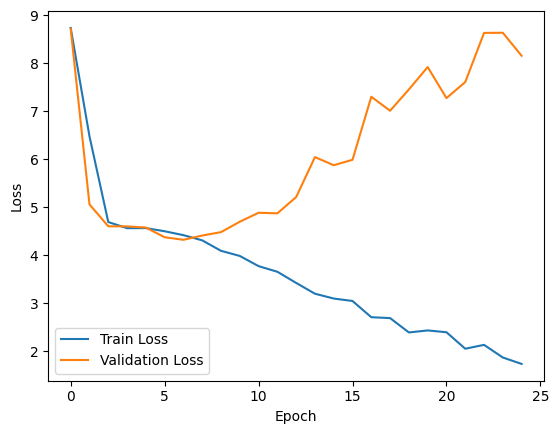

Test Accuracy - Condition: 0.4000, Type: 0.2000, Stains: 0.6000


In [ ]:


df = data.copy()  

class MultiOutputDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['images']).convert('RGB')
        condition = row['condition']
        type_label = row['type']
        stains = row['stains']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(condition, dtype=torch.long), torch.tensor(type_label, dtype=torch.long), torch.tensor(stains, dtype=torch.long)


train_df, test_val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_val_df, test_size=0.5, random_state=42)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = MultiOutputDataset(train_df, transform=transform)
val_dataset = MultiOutputDataset(val_df, transform=transform)
test_dataset = MultiOutputDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


condition_weights = compute_class_weight('balanced', classes=np.unique(df['condition']), y=df['condition'])
type_weights = compute_class_weight('balanced', classes=np.unique(df['type']), y=df['type'])
stains_weights = compute_class_weight('balanced', classes=np.unique(df['stains']), y=df['stains'])

condition_weights = torch.tensor(condition_weights, dtype=torch.float)
type_weights = torch.tensor(type_weights, dtype=torch.float)
stains_weights = torch.tensor(stains_weights, dtype=torch.float)


class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc_condition = nn.Linear(128, len(np.unique(df['condition'])))
        self.fc_type = nn.Linear(128, len(np.unique(df['type'])))
        self.fc_stains = nn.Linear(128, len(np.unique(df['stains'])))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        condition_out = self.fc_condition(x)
        type_out = self.fc_type(x)
        stains_out = self.fc_stains(x)
        return condition_out, type_out, stains_out

model = MultiOutputCNN()


criterion_condition = nn.CrossEntropyLoss(weight=condition_weights)
criterion_type = nn.CrossEntropyLoss(weight=type_weights)
criterion_stains = nn.CrossEntropyLoss(weight=stains_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 25
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, conditions, types, stains in train_loader:
        optimizer.zero_grad()
        condition_out, type_out, stains_out = model(images)
        loss_condition = criterion_condition(condition_out, conditions)
        loss_type = criterion_type(type_out, types)
        loss_stains = criterion_stains(stains_out, stains)
        loss = loss_condition + loss_type + loss_stains
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, conditions, types, stains in val_loader:
            condition_out, type_out, stains_out = model(images)
            loss_condition = criterion_condition(condition_out, conditions)
            loss_type = criterion_type(type_out, types)
            loss_stains = criterion_stains(stains_out, stains)
            loss = loss_condition + loss_type + loss_stains
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


model.eval()
correct_condition, correct_type, correct_stains = 0, 0, 0
total = 0
with torch.no_grad():
    for images, conditions, types, stains in test_loader:
        condition_out, type_out, stains_out = model(images)
        _, predicted_condition = torch.max(condition_out, 1)
        _, predicted_type = torch.max(type_out, 1)
        _, predicted_stains = torch.max(stains_out, 1)
        correct_condition += (predicted_condition == conditions).sum().item()
        correct_type += (predicted_type == types).sum().item()
        correct_stains += (predicted_stains == stains).sum().item()
        total += conditions.size(0)

accuracy_condition = correct_condition / total
accuracy_type = correct_type / total
accuracy_stains = correct_stains / total

print(f'Test Accuracy - Condition: {accuracy_condition:.4f}, Type: {accuracy_type:.4f}, Stains: {accuracy_stains:.4f}')


# (3) Transform images to tensors and save the tensor file

### transform imagesize and visualize

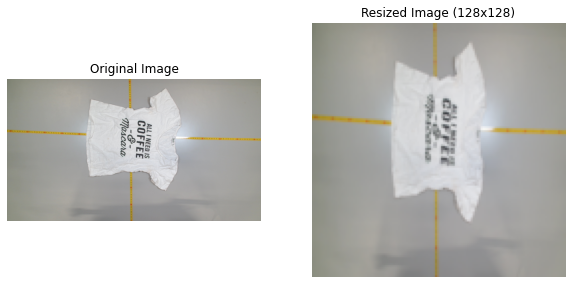

In [ ]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

image_path = 'data/data/images/front_2022_09_28_05_53_46.jpg' 
original_image = Image.open(image_path).convert('RGB')

resize_transform = transforms.Resize((128, 128))

resized_image = resize_transform(original_image)

original_image_np = np.array(original_image)
resized_image_np = np.array(resized_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(original_image_np)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(resized_image_np)
axs[1].set_title('Resized Image (128x128)')
axs[1].axis('off')

plt.show()


### save tensor

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

In [ ]:
df_tensor = data.copy()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_list = []
for idx, row in df_tensor.iterrows():
    image_path = row['image_name']
    print(image_path)
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    condition = torch.tensor(row['condition'], dtype=torch.long)
    type_label = torch.tensor(row['type'], dtype=torch.long)
    stains = torch.tensor(row['stains'], dtype=torch.long)
    data_list.append((image, condition, type_label, stains))

torch.save(data_list, our_path_data+'tensors/preprocessed_data_ladies_digi-proj.pt')

# (4) LOAD TENSORS-FILE

In [43]:
## Read tensors
import torch

data_list = torch.load(our_path_data+'tensors/preprocessed_data_ladies_digi-proj.pt')

In [ ]:
#df=pd.read_pickle(our_path_data+"dataframe.pkl")

In [44]:
data

,condition,type,stains,image_name
0,2,4,1,/content/drive/MyDrive/Digethic-ProjectWork/da...
1,1,7,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
2,3,4,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
3,1,0,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
4,4,2,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
...,...,...,...,...
11463,1,4,1,/content/drive/MyDrive/Digethic-ProjectWork/da...
11464,1,1,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
11465,4,2,0,/content/drive/MyDrive/Digethic-ProjectWork/da...
11466,1,7,1,/content/drive/MyDrive/Digethic-ProjectWork/da...


# (5) Second mCNN Modell Version with 
model version A: 2 convo-layer; no drop-out; 1 fc-layer;

In [22]:
import torch
from torch.utils.data import DataLoader, Dataset

class PreprocessedDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

train_size = int(0.8 * len(data_list))
val_size = int(0.1 * len(data_list))
test_size = len(data_list) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(data_list, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1/10, Train Loss: 4.0191, Val Loss: 3.8272
Epoch 2/10, Train Loss: 3.6037, Val Loss: 3.7178
Epoch 3/10, Train Loss: 3.3843, Val Loss: 3.5591
Epoch 4/10, Train Loss: 3.2002, Val Loss: 3.5554
Epoch 5/10, Train Loss: 2.9986, Val Loss: 3.5630
Epoch 6/10, Train Loss: 2.7954, Val Loss: 3.6163
Epoch 7/10, Train Loss: 2.5866, Val Loss: 3.6756
Epoch 8/10, Train Loss: 2.3675, Val Loss: 3.7314
Epoch 9/10, Train Loss: 2.1403, Val Loss: 3.8895
Epoch 10/10, Train Loss: 1.9258, Val Loss: 4.0643


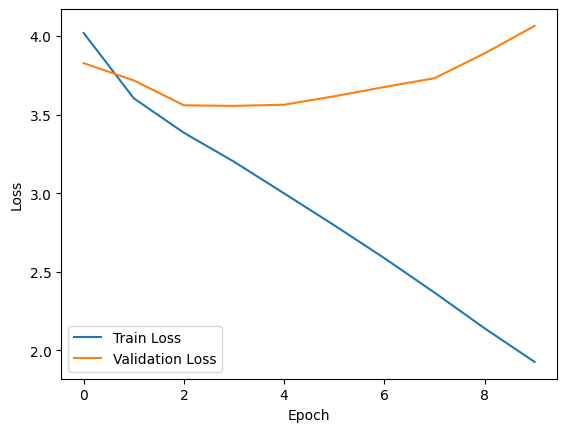

Test Accuracy - Condition: 0.3057, Type: 0.4643, Stains: 0.6115


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc_condition = nn.Linear(128, len(np.unique(df['condition'])))
        self.fc_type = nn.Linear(128, len(np.unique(df['type'])))
        self.fc_stains = nn.Linear(128, len(np.unique(df['stains'])))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        condition_out = self.fc_condition(x)
        type_out = self.fc_type(x)
        stains_out = self.fc_stains(x)
        return condition_out, type_out, stains_out

model = MultiOutputCNN()

condition_weights = compute_class_weight('balanced', classes=np.unique(df['condition']), y=df['condition'])
type_weights = compute_class_weight('balanced', classes=np.unique(df['type']), y=df['type'])
stains_weights = compute_class_weight('balanced', classes=np.unique(df['stains']), y=df['stains'])

condition_weights = torch.tensor(condition_weights, dtype=torch.float)
type_weights = torch.tensor(type_weights, dtype=torch.float)
stains_weights = torch.tensor(stains_weights, dtype=torch.float)

criterion_condition = nn.CrossEntropyLoss(weight=condition_weights)
criterion_type = nn.CrossEntropyLoss(weight=type_weights)
criterion_stains = nn.CrossEntropyLoss(weight=stains_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, conditions, types, stains in train_loader:
        optimizer.zero_grad()
        condition_out, type_out, stains_out = model(images)
        loss_condition = criterion_condition(condition_out, conditions)
        loss_type = criterion_type(type_out, types)
        loss_stains = criterion_stains(stains_out, stains)
        loss = loss_condition + loss_type + loss_stains
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, conditions, types, stains in val_loader:
            condition_out, type_out, stains_out = model(images)
            loss_condition = criterion_condition(condition_out, conditions)
            loss_type = criterion_type(type_out, types)
            loss_stains = criterion_stains(stains_out, stains)
            loss = loss_condition + loss_type + loss_stains
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.eval()
correct_condition, correct_type, correct_stains = 0, 0, 0
total = 0
with torch.no_grad():
    for images, conditions, types, stains in test_loader:
        condition_out, type_out, stains_out = model(images)
        _, predicted_condition = torch.max(condition_out, 1)
        _, predicted_type = torch.max(type_out, 1)
        _, predicted_stains = torch.max(stains_out, 1)
        correct_condition += (predicted_condition == conditions).sum().item()
        correct_type += (predicted_type == types).sum().item()
        correct_stains += (predicted_stains == stains).sum().item()
        total += conditions.size(0)

accuracy_condition = correct_condition / total
accuracy_type = correct_type / total
accuracy_stains = correct_stains / total

print(f'Test Accuracy - Condition: {accuracy_condition:.4f}, Type: {accuracy_type:.4f}, Stains: {accuracy_stains:.4f}')


# (6) THIRD/FINAL Model Version

Epoch 1/30, Train Loss: 4.4103, Val Loss: 4.3977
Epoch 2/30, Train Loss: 4.3838, Val Loss: 4.3997
Epoch 3/30, Train Loss: 4.3812, Val Loss: 4.3972
Epoch 4/30, Train Loss: 4.3389, Val Loss: 4.3164
Epoch 5/30, Train Loss: 4.2717, Val Loss: 4.2541
Epoch 6/30, Train Loss: 4.2223, Val Loss: 4.2416
Epoch 7/30, Train Loss: 4.2154, Val Loss: 4.2394
Epoch 8/30, Train Loss: 4.2088, Val Loss: 4.2345
Epoch 9/30, Train Loss: 4.2030, Val Loss: 4.2292
Epoch 10/30, Train Loss: 4.1912, Val Loss: 4.2254
Epoch 11/30, Train Loss: 4.1876, Val Loss: 4.2233
Epoch 12/30, Train Loss: 4.1849, Val Loss: 4.2230
Epoch 13/30, Train Loss: 4.1901, Val Loss: 4.2221
Epoch 14/30, Train Loss: 4.1881, Val Loss: 4.2215
Epoch 15/30, Train Loss: 4.1804, Val Loss: 4.2211
Epoch 16/30, Train Loss: 4.1817, Val Loss: 4.2210
Epoch 17/30, Train Loss: 4.1819, Val Loss: 4.2209
Epoch 18/30, Train Loss: 4.1832, Val Loss: 4.2209
Epoch 19/30, Train Loss: 4.1831, Val Loss: 4.2208
Epoch 20/30, Train Loss: 4.1829, Val Loss: 4.2208
Epoch 21/

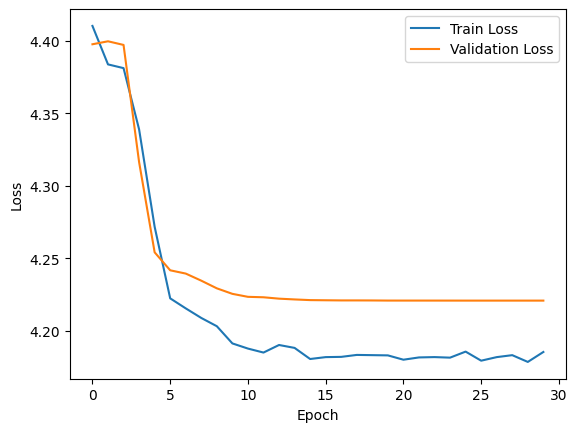

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split

# Custom Dataset class
class PreprocessedDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


train_size = int(0.8 * len(data_list))
val_size = int(0.1 * len(data_list))
test_size = len(data_list) - train_size - val_size

train_data, val_data, test_data = random_split(data_list, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=18, shuffle=True)
val_loader = DataLoader(val_data, batch_size=18, shuffle=False)
test_loader = DataLoader(test_data, batch_size=18, shuffle=False)

# Define the mCNN-Model
class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc_condition = nn.Linear(128, len(np.unique(df['condition'])))
        self.fc_type = nn.Linear(128, len(np.unique(df['type'])))
        self.fc_stains = nn.Linear(128, len(np.unique(df['stains'])))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 6 * 6) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        condition_out = F.softmax(self.fc_condition(x), dim=1)
        type_out = F.softmax(self.fc_type(x), dim=1)
        stains_out = F.softmax(self.fc_stains(x), dim=1)
        return condition_out, type_out, stains_out

model = MultiOutputCNN()


condition_weights = compute_class_weight('balanced', classes=np.unique(df['condition']), y=df['condition'])
type_weights = compute_class_weight('balanced', classes=np.unique(df['type']), y=df['type'])
stains_weights = compute_class_weight('balanced', classes=np.unique(df['stains']), y=df['stains'])

condition_weights = torch.tensor(condition_weights, dtype=torch.float)
type_weights = torch.tensor(type_weights, dtype=torch.float)
stains_weights = torch.tensor(stains_weights, dtype=torch.float)

criterion_condition = nn.CrossEntropyLoss(weight=condition_weights)
criterion_type = nn.CrossEntropyLoss(weight=type_weights)
criterion_stains = nn.CrossEntropyLoss(weight=stains_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, conditions, types, stains in train_loader:
        optimizer.zero_grad()
        condition_out, type_out, stains_out = model(images)
        loss_condition = criterion_condition(condition_out, conditions)
        loss_type = criterion_type(type_out, types)
        loss_stains = criterion_stains(stains_out, stains)
        loss = loss_condition + loss_type + loss_stains
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, conditions, types, stains in val_loader:
            condition_out, type_out, stains_out = model(images)
            loss_condition = criterion_condition(condition_out, conditions)
            loss_type = criterion_type(type_out, types)
            loss_stains = criterion_stains(stains_out, stains)
            loss = loss_condition + loss_type + loss_stains
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# (7) Modell Performance Accuracy Check

Test Accuracy - Condition: 0.2500, Type: 0.2979, Stains: 0.6368


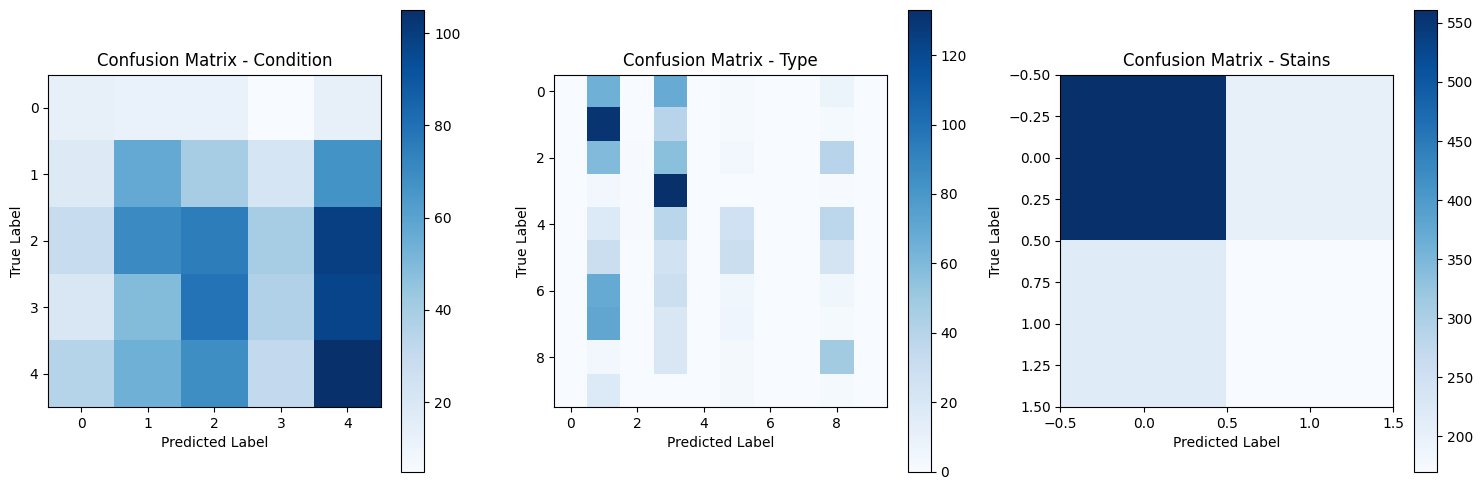

Classification Report - Condition:
              precision    recall  f1-score   support

           0       0.11      0.24      0.15        55
           1       0.24      0.28      0.26       204
           2       0.27      0.24      0.26       313
           3       0.27      0.13      0.18       282
           4       0.28      0.36      0.31       294

    accuracy                           0.25      1148
   macro avg       0.23      0.25      0.23      1148
weighted avg       0.26      0.25      0.25      1148

Classification Report - Type:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       143
           1       0.28      0.75      0.41       173
           2       0.33      0.01      0.01       159
           3       0.31      0.96      0.47       139
           4       0.00      0.00      0.00       121
           5       0.37      0.28      0.32       108
           6       0.00      0.00      0.00       108
           7 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset


correct_condition, correct_type, correct_stains = 0, 0, 0
total = 0
predicted_conditions, predicted_types, predicted_stains = [], [], []
true_conditions, true_types, true_stains = [], [], []

with torch.no_grad():
    for images, conditions, types, stains in test_loader:
        condition_out, type_out, stains_out = model(images)

        _, predicted_condition = torch.max(condition_out, 1)
        _, predicted_type = torch.max(type_out, 1)
        _, predicted_stains_batch = torch.max(stains_out, 1)

        predicted_conditions.extend(predicted_condition.cpu().numpy())
        predicted_types.extend(predicted_type.cpu().numpy())
        predicted_stains.extend(predicted_stains_batch.cpu().numpy())
        true_conditions.extend(conditions.cpu().numpy())
        true_types.extend(types.cpu().numpy())
        true_stains.extend(stains.cpu().numpy())

total = len(test_loader.dataset)
accuracy_condition = np.sum(np.array(predicted_conditions) == np.array(true_conditions)) / total
accuracy_type = np.sum(np.array(predicted_types) == np.array(true_types)) / total
accuracy_stains = np.sum(np.array(predicted_stains) == np.array(true_stains)) / total

print(f'Test Accuracy - Condition: {accuracy_condition:.4f}, Type: {accuracy_type:.4f}, Stains: {accuracy_stains:.4f}')

cm_condition = confusion_matrix(true_conditions, predicted_conditions)
cm_type = confusion_matrix(true_types, predicted_types)
cm_stains = confusion_matrix(true_stains, predicted_stains)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cm_condition, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Condition')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 2)
plt.imshow(cm_type, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Type')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(1, 3, 3)
plt.imshow(cm_stains, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Stains')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

print('Classification Report - Condition:')
print(classification_report(true_conditions, predicted_conditions, labels=np.unique(true_conditions)))

print('Classification Report - Type:')
print(classification_report(true_types, predicted_types, labels=np.unique(true_types)))

print('Classification Report - Stains:')
print(classification_report(true_stains, predicted_stains, labels=np.unique(true_stains)))
